# Tutorial (skip first TMLE stage)

`PyTMLE` offers maximum flexibility for the initial estimation of propensity scores, hazards and survival functions, beyond the default estimators that are implemented in the package. Estimates can be pre-computed outside of the package and then loaded into an `InitialEstimates` object, skipping the first TMLE stage altogether. This allows the user to exploit the full potential of TMLE, with flexible non-parametric estimation in the first step, and enabling inference according to semi-parametric efficiency theory after the second step has been completed. Note that, to retain the desired asymptotic properties, the estimators from the first step need to be optimized with respect to bias-variance tradeoff. Therefore, it is advisable to compute estimates in a super learner or a cross fitting setting.

In [1]:
import numpy as np
import pandas as pd
from pytmle import PyTMLE, InitialEstimates

In [2]:
data_df = pd.read_csv("hodgkins_disease.csv")
surv_0_df = pd.read_csv("initial_estimates/surv_0.csv")
surv_1_df = pd.read_csv("initial_estimates/surv_1.csv")
cens_surv_0_df = pd.read_csv("initial_estimates/cens_surv_0.csv")
cens_surv_1_df = pd.read_csv("initial_estimates/cens_surv_1.csv")
haz1_0_df = pd.read_csv("initial_estimates/haz1_0.csv")
haz1_1_df = pd.read_csv("initial_estimates/haz1_1.csv")
haz2_0_df = pd.read_csv("initial_estimates/haz2_0.csv")
haz2_1_df = pd.read_csv("initial_estimates/haz2_1.csv")
prop_0_df = pd.read_csv("initial_estimates/prop_0.csv", header=None)
prop_1_df = pd.read_csv("initial_estimates/prop_1.csv", header=None)

Important: Make sure that the rows refer to the same observations in all datasets. This can be achieved, for example, by asserting that all indices are the same:

In [3]:
# List of dataframes to check
dataframes = [surv_0_df, surv_1_df, cens_surv_0_df, cens_surv_1_df, haz1_0_df, haz1_1_df, haz2_0_df, haz2_1_df]

# Check if all dataframes have the same columns
all_col_equal = all(df.index.equals(dataframes[0].index) for df in dataframes)

dataframes += [data_df, prop_0_df, prop_1_df]
# Check if all dataframes have the same index
all_indices_equal = all(df.index.equals(dataframes[0].index) for df in dataframes)


print("All dataframes have the same index and columns:", all_indices_equal and all_col_equal)

All dataframes have the same index and columns: True


Now the pre-computed estimates are plugged into `InitialEstimates` objects, one for each counterfactual treatment group (0 and 1). You can also try to set some of the parameters to `None`; the estimates will then be computed using the default models in `PyTMLE`.

In [4]:
initial_estimates = {
    0: InitialEstimates(times = surv_0_df.columns.astype(float),
                        g_star_obs= 1 - data_df["chemo"].values,
                        propensity_scores=prop_0_df.values.squeeze(),
                        hazards=np.stack([haz1_0_df.values, haz2_0_df.values], axis=-1),
                        event_free_survival_function=surv_0_df.values,
                        censoring_survival_function=cens_surv_0_df.values),
    1: InitialEstimates(times = surv_1_df.columns.astype(float),
                        g_star_obs= data_df["chemo"].values,
                        propensity_scores=prop_1_df.values.squeeze(),
                        hazards=np.stack([haz1_1_df.values, haz2_1_df.values], axis=-1),
                        event_free_survival_function=surv_1_df.values,
                        censoring_survival_function=cens_surv_1_df.values),
}

The dictionary of `InitialEstimates` objects can now be passed when initializing `PyTMLE`. The TMLE update loop will build on the pre-computed initial estimates.

In [5]:
tmle = PyTMLE(data_df, 
              col_event_times="time", 
              col_event_indicator="status", 
              col_group="chemo", 
              target_times=[5.0, 10.0, 15.0, 20.0, 25.0], 
              g_comp=True,
              initial_estimates=initial_estimates,
              verbose=3)

tmle.fit(max_updates=100)

Using given propensity score estimates
Using given hazard and event-free survival estimates
Using given censoring survival estimates
Starting TMLE update loop...
Step 1: Norm PnEIC improved to 0.023621913378230025.
Step 2: Norm PnEIC improved to 0.0152424507085352.
Step 3: Norm PnEIC improved to 0.014366349408114718.
Step 4: Norm PnEIC improved to 0.01229243568118075.
Step 5: Norm PnEIC improved to 0.011751801911695708.
Step 6: Norm PnEIC improved to 0.011459429534079784.
Step 7: Norm PnEIC improved to 0.010283191040037899.
Step 8: Norm PnEIC improved to 0.010030571956088764.
Step 9: Norm PnEIC improved to 0.009803696348217658.
Step 10: Norm PnEIC improved to 0.009591962667480466.
Step 11: Norm PnEIC improved to 0.009393469729846922.
Step 12: Norm PnEIC improved to 0.009206806131014928.
Step 13: Norm PnEIC improved to 0.009030703279532561.
Step 14: Norm PnEIC improved to 0.008864009124449965.
Step 15: Norm PnEIC improved to 0.008705691693995952.
Step 16: Norm PnEIC improved to 0.008554

(<Figure size 1400x700 with 2 Axes>,
 array([<Axes: title={'center': 'Event 1'}, xlabel='Time', ylabel='Predicted Risk'>,
        <Axes: title={'center': 'Event 2'}, xlabel='Time', ylabel='Predicted Risk'>],
       dtype=object))

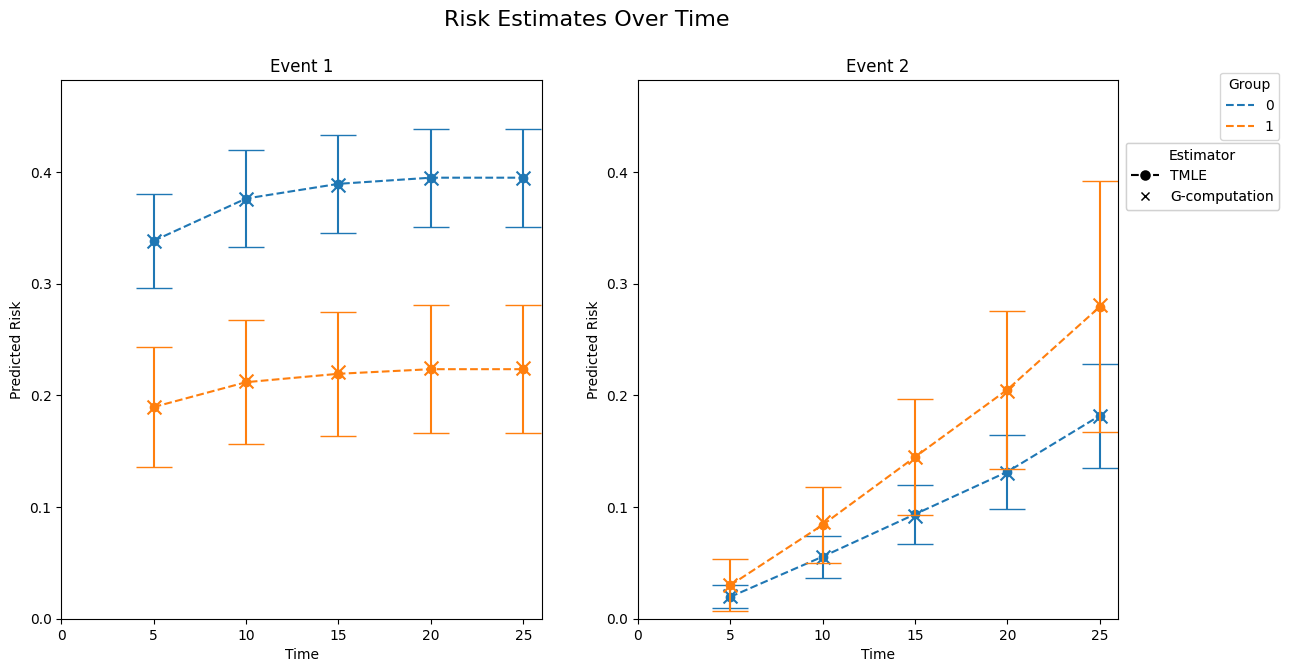

In [6]:
tmle.plot(g_comp=True)